# Bias Analysis of Sentiment Analysis Models and Datasets

The process of bias analysis is done in 3 steps:


1.   First, train and test on a logistic regression model
2.   Second, fine tune and test a standard dataset on another model
3.   Lastly, train the same model from step 2 on a toxicity dataset

Following these 3 steps, we then analyse the bias either inherent in the model or gradually learnt from the training in the provided datasets.



# 1. Basic test of Bias using Logistic Regression

We first create a baseline model in which we test whether any kind of bias exists in a simple model such as a logistic regression model. This model is trained on the Stanford Sentiment Treebank v2 (SST2) dataset and then tested on the Equity Evaluation Corpus (EEC) dataset.

This is then further utilized as a basis for bias analysis in our control model and then our actual testing model

### For obtaining the datasets from kaggle:

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jkhanbk1/sst2-dataset")

print("Path to dataset files:", path)

100%|██████████| 827k/827k [00:00<00:00, 91.5MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/jkhanbk1/sst2-dataset/versions/1


In [4]:
import os
# for the csv datasets
print(os.listdir('/root/.cache/kagglehub/datasets/jkhanbk1/sst2-dataset/versions/1/Finalv SST-2 dataset CSV format'))


['train.csv', 'unsup.csv', 'test.csv', 'val.csv']


In [5]:
import pandas as pd

train_data = '/root/.cache/kagglehub/datasets/jkhanbk1/sst2-dataset/versions/1/Finalv SST-2 dataset CSV format/train.csv'
test_data = '/root/.cache/kagglehub/datasets/jkhanbk1/sst2-dataset/versions/1/Finalv SST-2 dataset CSV format/test.csv'
val_data = '/root/.cache/kagglehub/datasets/jkhanbk1/sst2-dataset/versions/1/Finalv SST-2 dataset CSV format/val.csv'

train_df = pd.read_csv(train_data)
test_df = pd.read_csv(test_data)
val_df = pd.read_csv(val_data)

print(train_df.head())

   label                                           sentence
0      1  A stirring, funny and finally transporting re-...
1      0  Apparently reassembled from the cutting-room f...
2      0  They presume their audience won't sit still fo...
3      1  This is a visually stunning rumination on love...
4      1  Jonathan Parker's Bartleby should have been th...


### Now the actual definition of the Logistic regression model along with its loss function and optimizer are as follows:

In [13]:
import re, math, hashlib
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Configure device to use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim = 20000

# Simpler tokenizer and hashing vectorizer
token_pat = re.compile(r"\w+")
def tokenize(text):
  return token_pat.findall(str(text).lower())

class HashingVectorizer:
  def __init__(self, n_features=20000):
    self.n_features = n_features

  def _idx(self, token):
    return int(hashlib.md5(token.encode("utf-8")).hexdigest(), 16) % self.n_features

  def transform_one(self, text):
    x = torch.zeros(self.n_features, dtype=torch.float32)
    for tok in tokenize(text):
        x[self._idx(tok)] += 1.0
    n = torch.linalg.norm(x)
    if n > 0: x /= n
    return x

vectorizer = HashingVectorizer(input_dim)


# To wrap the pandas dataframe so that torch can read from it better
class FrameDataset(Dataset):
  def __init__(self, df, text_col='sentence', label_col='label'):
    self.texts = df[text_col].tolist()
    self.labels = df[label_col].tolist()

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, i):
    return vectorizer.transform_one(self.texts[i]), torch.tensor([self.labels[i]], dtype=torch.float32)

train_ds = FrameDataset(train_df)
test_ds   = FrameDataset(test_df)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)  # randomizes each epoch
test_loader   = DataLoader(test_ds,   batch_size=256, shuffle=False) # deterministic epochs


class LogisticRegression(nn.Module):
  def __init__(self, input_size):
    super(LogisticRegression, self).__init__()
    self.linear = nn.Linear(input_size, 1)

  def forward(self, x):
    y_predicted = torch.sigmoid(self.linear(x))
    return y_predicted


### Model Training Loop

In [14]:
def training_loop(train_loader, test_loader, model, num_epochs, criterion, optimizer, device):
  losses = []
  acc_vals = []

  for epoch in range(num_epochs):
    # Train the model
    model.train()
    total_loss = 0.0
    for xb, yb in train_loader:
      xb, yb = xb.to(device), yb.to(device)
      optimizer.zero_grad()
      out_logits = model(xb)
      loss = criterion(out_logits, yb)
      loss.backward()
      optimizer.step()
      total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(train_loader.dataset)
    losses.append(avg_loss)

  # Evaluate the model in the current epoch
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
      for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = (model(xb) >= 0.5).long()
        correct += (preds == yb.long()).sum().item()
        total += yb.size(0) # no of elements in the tensor
      acc = correct / total
      acc_vals.append(acc)
      print(f"Epoch {epoch + 1}: train_loss={avg_loss:.4f}  val_acc={acc:.4f}")
  return losses, acc_vals


### Function to run an experiment on different models with different hyperparameters

In [17]:
def run_experiment(lr, num_epochs, train_loader, test_loader, input_dim, device):
  model = LogisticRegression(input_dim).to(device)
  criterion = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  return training_loop(train_loader, test_loader, model, num_epochs, criterion, optimizer, device)

In [20]:
learning_rates = [0.001, 0.005, 0.01, 0.05]
num_epochs = 10
results = {}

for lr in learning_rates:
    print(f"\n--- LR = {lr} ---")
    train_loss, val_acc = run_experiment(lr, num_epochs, train_loader, test_loader, input_dim, device)
    results[lr] = (train_loss, val_acc)


--- LR = 0.001 ---
Epoch 0: train_loss=0.7113  val_acc=0.5008
Epoch 1: train_loss=0.7071  val_acc=0.5008
Epoch 2: train_loss=0.7033  val_acc=0.5008
Epoch 3: train_loss=0.6999  val_acc=0.5008
Epoch 4: train_loss=0.6968  val_acc=0.5008
Epoch 5: train_loss=0.6941  val_acc=0.5008
Epoch 6: train_loss=0.6917  val_acc=0.5008
Epoch 7: train_loss=0.6896  val_acc=0.5008
Epoch 8: train_loss=0.6877  val_acc=0.5008
Epoch 9: train_loss=0.6860  val_acc=0.5014

--- LR = 0.005 ---
Epoch 0: train_loss=0.7049  val_acc=0.5008
Epoch 1: train_loss=0.6903  val_acc=0.5008
Epoch 2: train_loss=0.6820  val_acc=0.5030
Epoch 3: train_loss=0.6755  val_acc=0.5091
Epoch 4: train_loss=0.6694  val_acc=0.5354
Epoch 5: train_loss=0.6633  val_acc=0.5733
Epoch 6: train_loss=0.6576  val_acc=0.6167
Epoch 7: train_loss=0.6521  val_acc=0.6491
Epoch 8: train_loss=0.6469  val_acc=0.6716
Epoch 9: train_loss=0.6421  val_acc=0.6875

--- LR = 0.01 ---
Epoch 0: train_loss=0.6988  val_acc=0.5008
Epoch 1: train_loss=0.6793  val_acc=0.

# Plots for the accuracy and losses

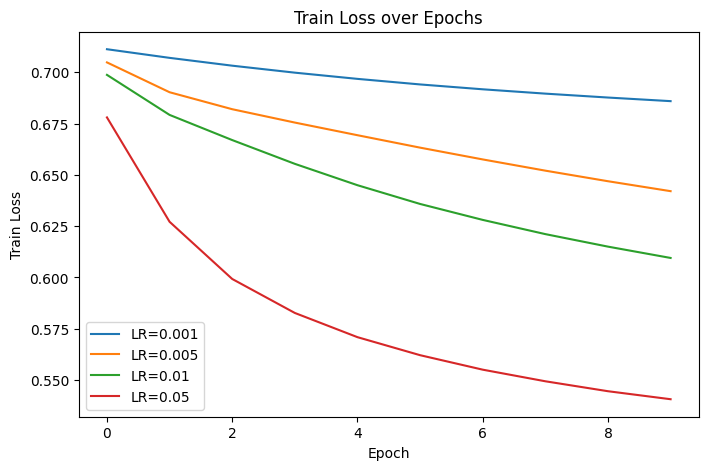

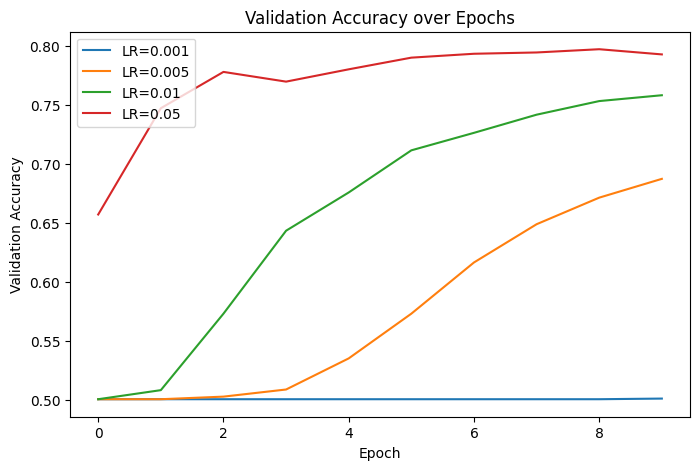

In [21]:
import matplotlib.pyplot as plt

# Plot for loss
plt.figure(figsize=(8,5))
for lr in learning_rates:
    train_loss, _ = results[lr]
    plt.plot(train_loss, label=f"LR={lr}")
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Train Loss over Epochs")
plt.legend()
plt.show()
print()

# Plot for accuracy
plt.figure(figsize=(8,5))
for lr in learning_rates:
    _, val_acc = results[lr]
    plt.plot(val_acc, label=f"LR={lr}")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy over Epochs")
plt.legend()
plt.show()
